# Multi modal model

In [ ]:
%pip install --upgrade pip
%pip install tensorflow
%pip install yfinance
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install pytorch-lightning
%pip install transformers
%pip install git+https://github.com/paulgavrikov/visualkeras

In [645]:
import yfinance as yf
import re
import nltk
import tensorflow as tf
import visualkeras
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, date
import torch.utils.data as td
import pytorch_lightning as pl
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
from sklearn.model_selection import train_test_split
%matplotlib inline
nltk.download("stopwords")
from sklearn.preprocessing import MinMaxScaler
import nltk
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
# from keras.optimizer import Adam
# from keras.optimizers.Adam
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import TCN, Dense

from keras.layers import LSTM,Conv1D, Dense, Embedding,TCN, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate
from keras.layers import LSTM,Conv1D, Dense, Embedding,GlobalMaxPooling1D, Input,Bidirectional, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computing\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Fetch financial record from 1st January 2015 - 31st May 2021

In [575]:
start_date ='2014-01-01'
end_date = '2021-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [576]:
price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [577]:
price = price.reset_index()
price.index = pd.to_datetime(price['Date'], format='%Y-%m-%d')
# price = price.drop(['Date'], axis=1)

In [578]:
price_2= price.Close.to_frame()
price['PriceChange'] = price['Close'].pct_change() * 100 
price['Label'] = np.where(price['PriceChange'] > 0, 1, 0)

price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0.02)

# Calculate the percentage change in the Close price
price['Close_pct_change'] = price['Close'].pct_change()

# Create a binary column indicating if the Close price increased (1) or decreased (0)
price['Close_increase'] = (price['Close_pct_change'] > 0).astype(int)

# Fill any NaN values in the new columns with 0 (for the first row)
price['Close_pct_change'].fillna(0, inplace=True)
price['Close_increase'].fillna(0, inplace=True)

# Drop the 'Close_pct_change' column if you no longer need it
price.drop('Close_pct_change', axis=1, inplace=True)


In [579]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,change_label,Close_increase
Date,,,,,,,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,0,NaN,NaN,False,0
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-7.192558,0,-0.071926,-0.074643,False,0
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-6.984265,0,-0.069843,-0.072402,False,0
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,3.573492,1,0.035735,0.035111,True,1
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-2.465854,0,-0.024659,-0.024968,False,0


In [580]:
price.shape

(2662, 13)

### Compute moving average

In [581]:
# We will compute 7, 14, 21 simple moving average moving average 
# Due to the high volatility nature of crypto currency we chose a 1 day lag

lag = 1  # Number of lags
price['Close Lagged Price'] = price['Close'].shift(lag)
price['sma7'] = price['Close'].rolling(window=7).mean()
price['sma14'] = price['Close'].rolling(window=14).mean()
price['sma21'] = price['Close'].rolling(window=21).mean()


price['ema12'] = price['Close'].ewm(span=12, adjust=False).mean()
price['ema26'] = price['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
price['MACD line'] = price['ema12'] - price['ema26']

# Calculate Signal Line
price['Signal line'] = price['MACD line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
price['MACD histogram'] = price['MACD line'] - price['Signal line']

In [582]:
window = 14  # Number of periods for RSI calculation

# Calculate price changes
delta = price['Close'].diff()

# Calculate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

price['rsi'] = rsi


In [583]:
price.shape

(2662, 23)

In [584]:
price.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,...,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-26,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.752840,1,0.007528,...,50429.859375,49613.073103,48354.407924,48720.261347,49445.238442,50481.798187,-1036.559746,-1828.605036,792.045291,52.409775
2021-12-27,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.332807,0,-0.003328,...,50809.515625,50150.236049,48633.189174,48723.013393,49629.112215,50493.547801,-864.435586,-1635.771146,771.335561,66.874820
2021-12-28,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-6.025943,0,-0.060259,...,50640.417969,49957.699219,48702.919364,48574.859561,49315.226562,50278.385406,-963.158844,-1501.248686,538.089842,53.368353
2021-12-29,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,-2.404228,0,-0.024042,...,47588.855469,49645.727679,48527.775670,48381.522135,48873.608773,49994.409519,-1120.800746,-1425.159098,304.358352,40.817228
2021-12-30,2021-12-30,46490.605469,47879.964844,46060.312500,47178.125000,47178.125000,26686491018,1.579112,1,0.015791,...,46444.710938,49130.525670,48492.968471,48357.998512,48612.765116,49785.795851,-1173.030735,-1374.733425,201.702690,48.104370


In [585]:
price = price.dropna()

In [586]:
price.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,...,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
count,2642,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2.642000e+03,2642.000000,2642.000000,2642.000000,...,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000,2642.000000
mean,2018-05-19 12:00:00,10809.356646,11105.882556,10485.413409,10825.280610,10825.280610,1.457101e+10,0.264425,0.544663,0.002644,...,10807.548571,10771.073457,10706.084813,10642.841119,10724.841664,10591.593633,133.248031,135.297095,-2.049064,54.558437
min,2014-10-07 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06,-37.169539,0.000000,-0.371695,...,178.102997,204.545569,222.873070,226.947285,224.309373,230.699121,-5053.274080,-4438.999056,-1694.518206,4.699489
25%,2016-07-28 06:00:00,607.058258,609.840744,604.667252,607.018524,607.018524,8.015038e+07,-1.274733,0.000000,-0.012747,...,606.788498,606.542722,605.642628,606.596096,606.298141,603.194001,-31.795277,-32.885728,-21.387952,40.875973
50%,2018-05-19 12:00:00,6229.204834,6368.270020,6082.739990,6233.429932,6233.429932,4.996205e+09,0.204241,1.000000,0.002042,...,6227.395020,6317.852400,6340.091396,6358.645240,6386.941510,6431.114834,6.289325,6.013963,0.657430,54.401936
75%,2020-03-09 18:00:00,10232.345703,10436.789062,9958.710205,10239.429443,10239.429443,2.440467e+10,1.837115,1.000000,0.018371,...,10233.825195,10279.380650,10181.565116,10199.195754,10242.626910,10263.817750,199.781003,202.882107,32.218136,67.833640
max,2021-12-30 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,25.247169,1.000000,0.252472,...,67566.828125,65510.879464,63983.060826,63016.876488,64182.504548,62406.255181,5273.808690,4517.102703,1305.313389,99.765628
std,NaN,15727.298150,16161.481949,15232.254630,15737.360565,15737.360565,2.010647e+10,3.890938,0.498095,0.038909,...,15722.770769,15670.491608,15588.890306,15509.653816,15592.102669,15386.819969,928.102319,880.988572,255.836865,18.502425


In [588]:
price_corr = price.drop(['Date'], axis=1)

In [589]:
price_corr.corr()

,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,...,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
Open,1.000000,0.999527,0.999073,0.998816,0.998816,0.734847,-0.017716,-0.037540,-0.017716,-0.019275,...,0.999993,0.998707,0.996042,0.993077,0.997825,0.993508,0.292278,0.322119,-0.048935,-0.002267
High,0.999527,1.000000,0.999029,0.999488,0.999488,0.738278,-0.002213,-0.027443,-0.002213,-0.004301,...,0.999522,0.998552,0.995887,0.992903,0.997705,0.993335,0.293120,0.322299,-0.046500,0.001193
Low,0.999073,0.999029,1.000000,0.999388,0.999388,0.727427,0.000540,-0.025461,0.000540,-0.000536,...,0.999078,0.997757,0.994836,0.991831,0.996854,0.992322,0.295624,0.322982,-0.039766,0.003312
Close,0.998816,0.999488,0.999388,1.000000,1.000000,0.733806,0.012583,-0.017411,0.012583,0.010859,...,0.998825,0.997874,0.994954,0.991897,0.996969,0.992363,0.296877,0.324129,-0.039173,0.005740
Adj Close,0.998816,0.999488,0.999388,1.000000,1.000000,0.733806,0.012583,-0.017411,0.012583,0.010859,...,0.998825,0.997874,0.994954,0.991897,0.996969,0.992363,0.296877,0.324129,-0.039173,0.005740
Volume,0.734847,0.738278,0.727427,0.733806,0.733806,1.000000,0.003285,-0.028512,0.003285,-0.003461,...,0.734807,0.735839,0.732262,0.727191,0.733194,0.725979,0.281784,0.314571,-0.061014,0.035648
PriceChange,-0.017716,-0.002213,0.000540,0.012583,0.012583,0.003285,1.000000,0.655320,1.000000,0.997838,...,-0.017735,-0.013353,-0.016487,-0.017712,-0.013608,-0.017191,0.056397,0.023067,0.125159,0.271130
Label,-0.037540,-0.027443,-0.025461,-0.017411,-0.017411,-0.028512,0.655320,1.000000,0.655320,0.651260,...,-0.037621,-0.033529,-0.035456,-0.035853,-0.033712,-0.035451,0.021361,0.000024,0.077408,0.223271
change,-0.017716,-0.002213,0.000540,0.012583,0.012583,0.003285,1.000000,0.655320,1.000000,0.997838,...,-0.017735,-0.013353,-0.016487,-0.017712,-0.013608,-0.017191,0.056397,0.023067,0.125159,0.271130
log_change,-0.019275,-0.004301,-0.000536,0.010859,0.010859,-0.003461,0.997838,0.651260,0.997838,1.000000,...,-0.019294,-0.015055,-0.018260,-0.019504,-0.015342,-0.018965,0.056672,0.022915,0.126679,0.273075


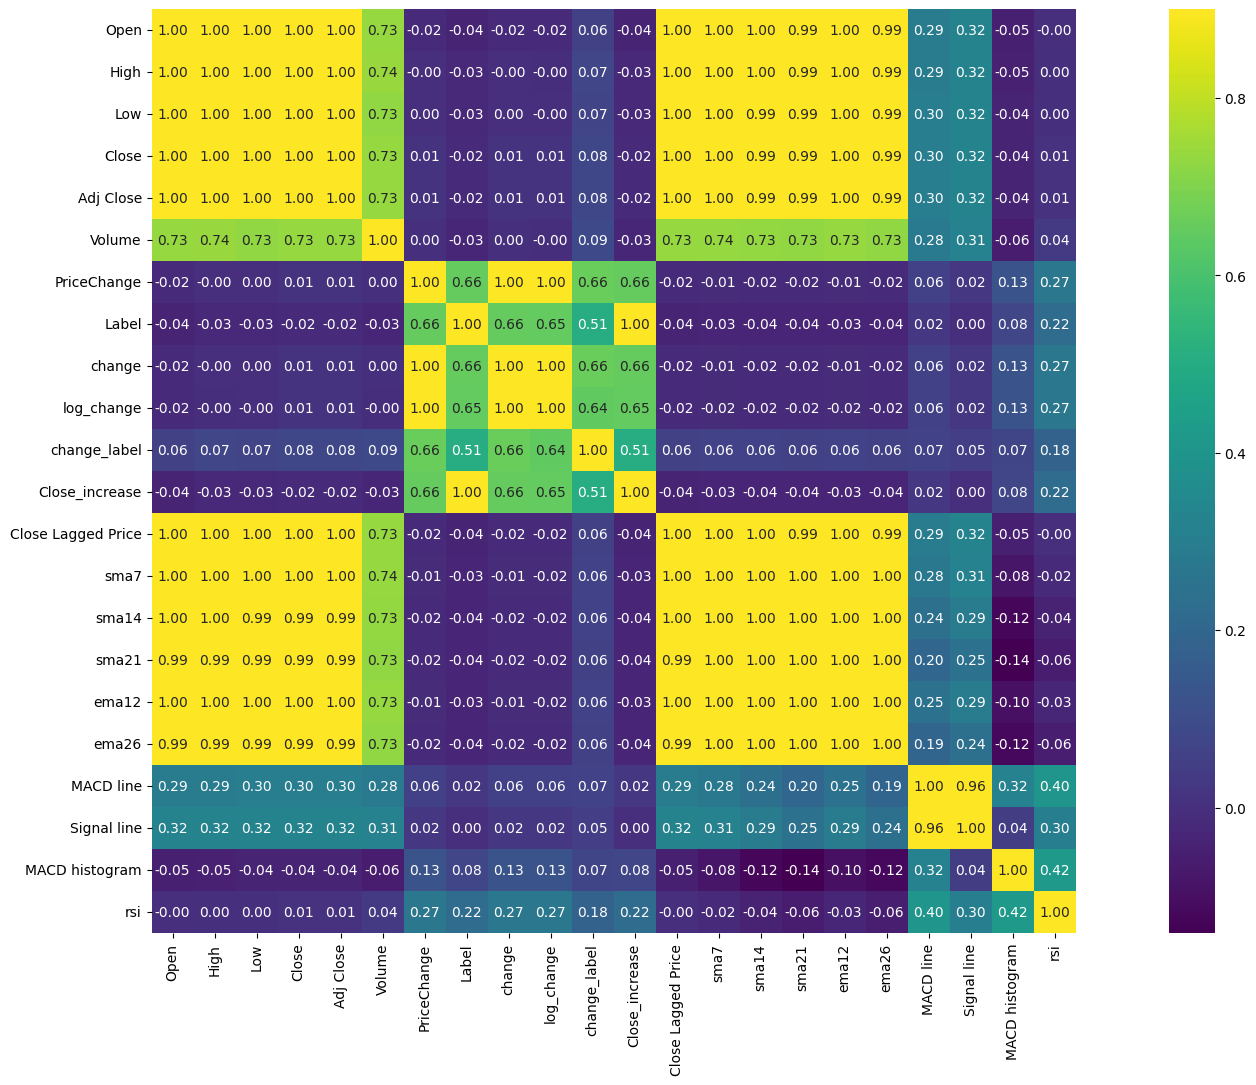

In [590]:
corrmat = price_corr.corr()

ax = plt.subplots(figsize = (24, 12))

sns.heatmap(corrmat, vmax = 0.9, square = True, annot = True, fmt = '0.2f', cmap = 'viridis');

c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Label', ylabel='count'>

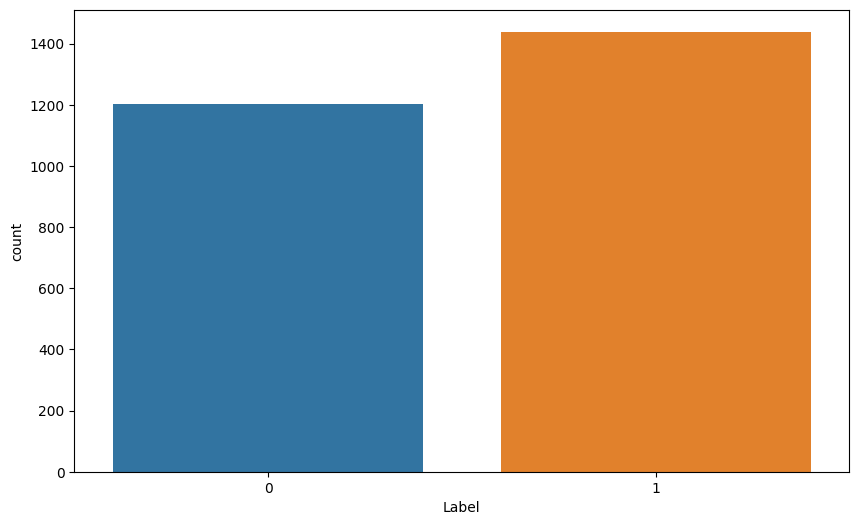

In [591]:
plt.figure(figsize = (10, 6))

sns.countplot(x='Label', data = price)

In [592]:
price['Label'].value_counts()

Label
1    1439
0    1203
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

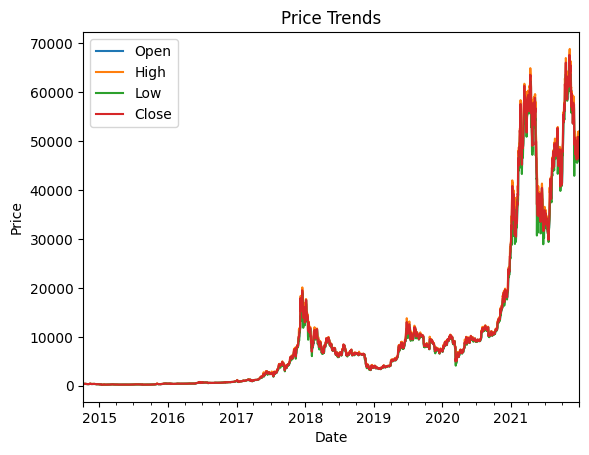

In [593]:
# Plotting Open, High, Low, Close
plt.figure(figsize=(12, 6))
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

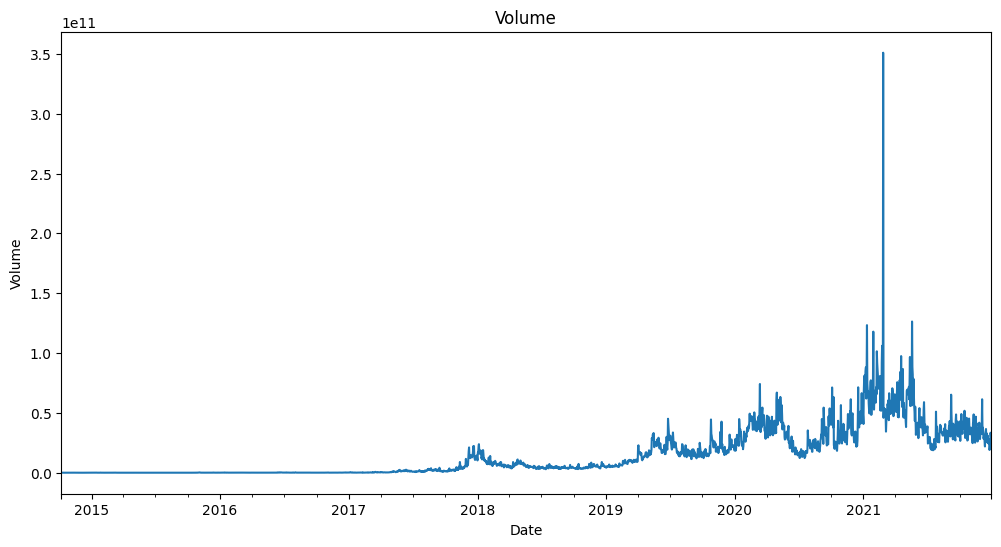

In [594]:
# Plotting Volume
plt.figure(figsize=(12, 6))
price['Volume'].plot()
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

<Figure size 1200x600 with 0 Axes>

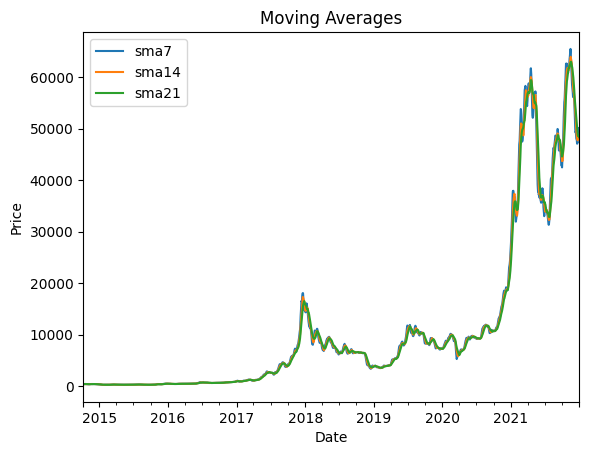

In [595]:
# Plotting Moving Averages
plt.figure(figsize=(12, 6))
price[['sma7', 'sma14', 'sma21']].plot()
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

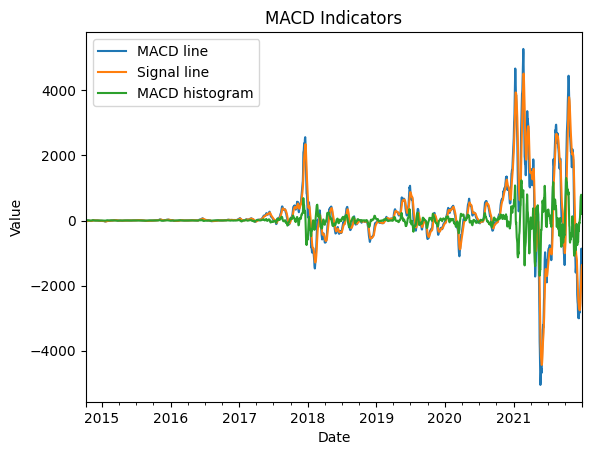

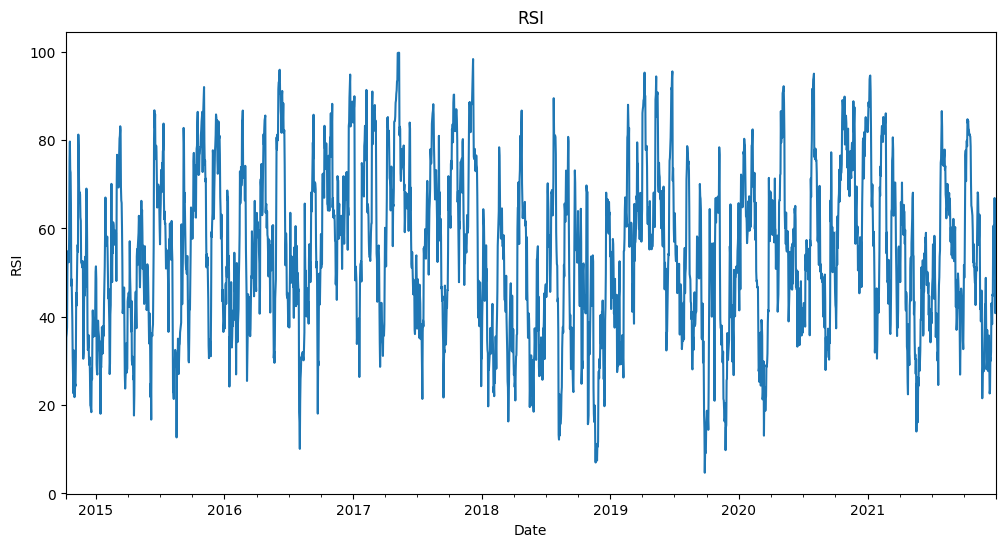

In [596]:
# Plotting MACD Line, Signal Line, MACD Histogram
plt.figure(figsize=(12, 6))
price[['MACD line', 'Signal line', 'MACD histogram']].plot()
plt.title('MACD Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 6))
price['rsi'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

### Process tweets

In [598]:
tweets_2015 = pd.read_csv('../archive/data/tweets/combined_tweets_2015_labeled.csv')
tweets_2016 = pd.read_csv('../archive/data/tweets/combined_tweets_2016_labeled.csv')
tweets_2017 = pd.read_csv('../archive/data/tweets/combined_tweets_2017_labeled.csv')
tweets_2018 = pd.read_csv('../archive/data/tweets/combined_tweets_2018_labeled.csv')
tweets_2019 = pd.read_csv('../archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv')
tweets_2020 = pd.read_csv('../archive/data/tweets/combined_tweets_2020_labeled.csv')
tweets_2021 = pd.read_csv('../archive/data/tweets/combined_tweets_2021_jan_may_labeled.csv')

In [599]:
frames = [tweets_2015,tweets_2016,tweets_2017,tweets_2018,tweets_2019,tweets_2020,tweets_2021]
tweets = pd.concat(frames,ignore_index=True)

In [600]:
tweets = tweets.drop(['label_up5','label_up2','label_down5','label_down2','Unnamed: 0'],axis=1)

In [601]:
tweets.rename(columns={"date": "Date"}, inplace=True)

In [602]:
tweets['text_split'] = tweets['text_split'].str[:200]

In [603]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']
    if compound_score >= 0.05:
        return 1  # Positive sentiment
    elif compound_score <= -0.05:
        return -1  # Negative sentiment
    else:
        return 0  # Neutral sentiment

# Apply sentiment analysis and add a binary sentiment column
tweets['sentiment'] = tweets['text_split'].apply(get_sentiment)


In [604]:
# Count the occurrences of zeros and ones in the 'Binary_Sentiment' column
sentiment_counts = tweets['sentiment'].value_counts()

# Display the counts
print(sentiment_counts)


sentiment
 1    221485
-1     86922
 0     33655
Name: count, dtype: int64


In [606]:
# Convert the 'Date' column to datetime
tweets['Date'] = pd.to_datetime(tweets['Date'])

# Group by 'Date' and calculate the most frequent sentiment for each day
tweets = tweets.groupby('Date')['sentiment'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Display the consolidated DataFrame
print(tweets)


           Date  sentiment
0    2015-01-01          1
1    2015-01-02          1
2    2015-01-03          1
3    2015-01-04          1
4    2015-01-05          1
...         ...        ...
2242 2021-05-27          1
2243 2021-05-28          1
2244 2021-05-29          1
2245 2021-05-30          1
2246 2021-05-31          1

[2247 rows x 2 columns]


In [607]:
# Count the occurrences of zeros and ones in the 'Binary_Sentiment' column
sentiment_counts = tweets['sentiment'].value_counts()

# Display the counts
print(sentiment_counts)


sentiment
 1    2224
-1      21
 0       2
Name: count, dtype: int64


In [608]:
price['Date'] = pd.to_datetime(price['Date'])

In [609]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [512]:
tweets

,Date,sentiment
0,2015-01-01,1
1,2015-01-02,1
2,2015-01-03,1
3,2015-01-04,1
4,2015-01-05,1
...,...,...
2242,2021-05-27,1
2243,2021-05-28,1
2244,2021-05-29,1
2245,2021-05-30,1


In [610]:
price = price.drop(['Date'],axis=1)

In [613]:
multi_modal = tweets.merge(price, how='outer', on=['Date'])

In [615]:
multi_modal = multi_modal.dropna()

In [526]:
multi_modal.index = pd.to_datetime(multi_modal['Date'], format='%Y-%m-%d')

In [618]:
multi_modal = multi_modal.dropna()

In [619]:
multi_modal = multi_modal.drop(['Date'], axis=1)

In [620]:
multi_modal['change_label'] = multi_modal['change_label'].apply(lambda x: 1 if x else 0)

In [ ]:
multi_modal.info()

In [622]:
col = list(multi_modal)[0:len(multi_modal)]

In [625]:
df_for_training = multi_modal[col].astype(float)
scaler  = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [628]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)


In [ ]:
X,y = df_to_X_y(df_for_training_scaled)

In [640]:
import numpy as np

def df_to_X_y_with_past_and_future_multivirate(df,df_scaled, n_future, n_past):
    X = []
    y = []
    for i in range(n_past, len(df_scaled) - n_future + 1):
        # X.append(df.iloc[i - n_past:i, :].values)
        # y.append(df.iloc[i + n_future - 1:i + n_future, 0].values)

        X.append(df_scaled[i - n_past:i, 0:df.shape[1]])
        y.append(df_scaled[i + n_future - 1:i + n_future, 0])
    X, y = np.array(X), np.array(y)
    return X, y


In [657]:
n = len(multi_modal)

In [658]:
X,y = df_to_X_y_with_past_and_future_multivirate(df_for_training,df_for_training_scaled,1,14)
X_train, y_train = X[0:int(n*0.7)],y[0:int(n*0.7)]
X_val, y_val = X[int(n*0.7):int(n*0.9)],y[int(n*0.7):int(n*0.9)]
X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]


### Utility methods

In [660]:
def plot_training_history(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['mean_absolute_error'], label='train_mae')
    plt.plot(history.history['val_mean_absolute_error'], label='val_mae')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

In [661]:
EPOCHS = 20

In [ ]:
def compile_and_fit(model, x, y, epochs=EPOCHS, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(x, y, epochs= epochs,batch_size=32, validation_split=0.33,shuffle=False, callbacks=[early_stopping])
    return history

### Baseline model

### Vanilla LSTM layer

In [ ]:
base_model_1 = Sequential()
base_model_1.add(LSTM(32,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
base_model_1.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_1, to_file='base_model_1.png').show() # write and show

### Standard LSTM layer with 32 units

In [663]:
base_model_2 = Sequential()
base_model_2.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))  # Add an LSTM layer
base_model_2.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_2, to_file='base_model_2.png').show() # write and show

### Bidirectional LSTM layer with 64 units

In [670]:
base_model_3 = Sequential()
base_model_3.add(Bidirectional(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False)))  # Add a Bidirectional LSTM layer
base_model_3.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_3, to_file='base_model_3.png').show() # write and show

In [676]:
base_model_4 = Sequential()
base_model_4.add(Conv1D(64, kernel_size=3, activation='relu'))
base_model_4.add(MaxPooling1D(pool_size=2))
base_model_4.add(LSTM(64))
base_model_4.add(Dense(32, activation='relu'))
base_model_4.add(Dropout(0.2))
base_model_4.add(Dense(y_train.shape[1]))
# visualkeras.layered_view(base_model_4, to_file='text_model.png').show() 

### ConvLSTM model

In [675]:
# Create a ConvLSTM model
base_model_5 = Sequential()
base_model_5.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True, input_shape=(X_train.shape[0], X_train.shape[1],X_train.shape[2],3)))
base_model_5.add(BatchNormalization())
base_model_5.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True))
base_model_5.add(BatchNormalization())
base_model_5.add(Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same'))


### Gated Recurrent Unit (GRU)

In [674]:
base_model_6 = Sequential()
base_model_6.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_6.add(Dense(y_train.shape[1], activation='softmax'))

### Bidirectional LSTM (BiLSTM)

In [673]:
base_model_7 = Sequential()
base_model_7.add(Bidirectional(LSTM(64), input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_7.add(Dense(y_train.shape[1], activation='softmax'))

### Stacked LSTM

In [672]:
base_model_8 = Sequential()
base_model_8.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_8.add(LSTM(64, return_sequences=True))
base_model_8.add(LSTM(64))
base_model_8.add(Dense(y_train.shape[1], activation='softmax'))

### LSTM with Attention Mechanism

In [671]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = LSTM(64, return_sequences=True)(inputs)
attention = Attention()([lstm, lstm])  # Add attention mechanism
output = Dense(y_train.shape[1], activation='softmax')(attention)
base_model_9 = Model(inputs, output)

### Temporal Convolutional Networks (TCN):

In [680]:
from keras.layers import TCN, Dense
base_model_10 = Sequential()
base_model_10.add(TCN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
base_model_10.add(Dense(y_train.shape[1], activation='softmax'))

ImportError: cannot import name 'TCN' from 'keras.layers' (c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\layers\__init__.py)

In [651]:
base_model_11 = Sequential()
base_model_11.add(LSTM(units=64,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
base_model_11.add(LSTM(units=32,activation='relu', return_sequences=False))
base_model_11.add(Dropout(0.2))
base_model_11.add(Dense(y_train.shape[1]))
cp = ModelCheckpoint('model1/', save_best_only=True)
base_model_11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
base_model_12 = Sequential()
base_model_12.add(LSTM(64,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
base_model_12.add(LSTM(32,activation='relu',return_sequences=False))
base_model_12.add(Dense(y_train.shape[1]))

In [667]:
models = [
    ('Vanilla LSTM layer', base_model_1),
    ('Standard LSTM layer with 32 units', base_model_2),
    ('Bidirectional LSTM layer with 64 units', base_model_3),
    ('Base model 4', base_model_4),
    ('ConvLSTM model', base_model_5),
    ('Gated Recurrent Unit (GRU)', base_model_6),
    ('Bidirectional LSTM (BiLSTM)', base_model_7),
    ('Stacked LSTM', base_model_8),
    ('LSTM with Attention Mechanism', base_model_9),
    ('Temporal Convolutional Networks (TCN)', base_model_10),
    ('LSTM with Attention', base_model_11),
    ('Base model 12', base_model_12)
]

NameError: name 'base_model_1' is not defined

In [ ]:
# new_future = 90
# forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=new_future,freq='1d').tolist

In [ ]:
# forecast_copies = np.repeat(forecast,df_for_training.shape[1], axis=1)
# y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [ ]:
# forecast_dates = []

# for time_i in forecast_period_dates:
#     forecast_dates.append(time_i.date())

# df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})

# df_forecast['Date']= pd.to_datetime(df_forecast['Date'])


# original = df[['Date','Open']]

# original['Date'] = pd.to_datetime(original['Date'])
# original = original.loc[original['Date']>= '2020-5-1']



In [385]:
from keras.optimizers import Adam

In [386]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train,y_train,validation_data=(X_val,y_val), epochs=10, callbacks=[cp])

In [405]:
def train_X_to_y(df, n_future, n_past):
    train_X = []
    train_Y =[]
    for i in range(n_past,len(df) - n_future + 1):
        train_X.append(df[i - n_past:i, 0:df.shape[1]])
        train_Y.append(df[i + n_future - 1:i+n_future,0])
    train_X, train_Y = np.array(train_X), np.array(train_Y)    
    return train_X, train_Y 

In [ ]:
model = Sequential()
model.add(LSTM(64,activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dense(trainY.shape[1]))

In [ ]:
model.summary()

In [388]:
from keras.models import load_model
model1 = load_model('model1/')

In [389]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train predictions' : train_predictions, 'Actuals': y_train})
train_results

50/50 [==============================] - 0s 1ms/step


,Train predictions,Actuals
0,-0.638452,-0.651311
1,-0.638991,-0.650630
2,-0.639405,-0.651548
3,-0.639340,-0.650959
4,-0.638910,-0.652262
...,...,...
1567,0.039902,0.116292
1568,0.038054,0.122571
1569,0.036073,0.119755
1570,0.034375,0.127127


<Axes: >

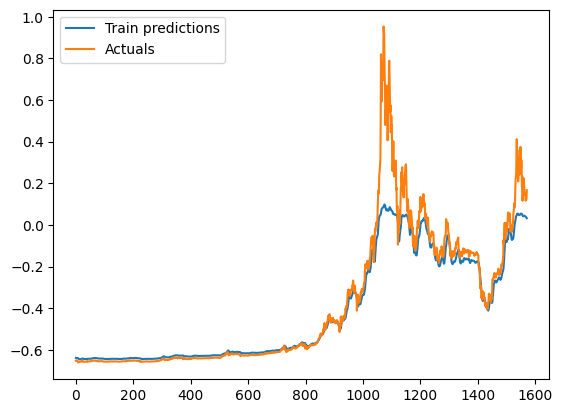

In [390]:
train_results.plot()

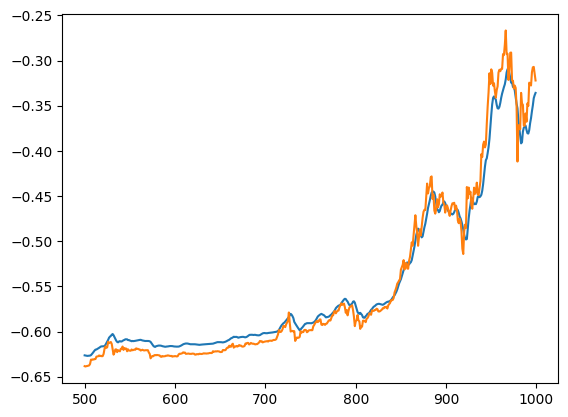

In [393]:
plt.plot(train_results['Train predictions'][500:1000])
plt.plot(train_results['Actuals'][500:1000])

In [394]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Train predictions' : val_predictions, 'Actuals': y_val})
val_results

15/15 [==============================] - 0s 1ms/step


,Train predictions,Actuals
0,0.033781,0.193290
1,0.038923,0.203186
2,0.041688,0.228537
3,0.043501,0.240935
4,0.045142,0.310707
...,...,...
445,0.050215,0.305394
446,0.050922,0.319950
447,0.051827,0.395725
448,0.054581,0.407601


In [222]:
token, t= tokenize_pad_sequences(multi_modal['top_100_words'])

In [223]:
multi_modal.shape

(2247, 25)

In [224]:
len(token)

2247

In [225]:
multi_modal['text_embeddings']= {}

C:\Users\Computing\AppData\Local\Temp\ipykernel_7300\4285133442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_modal['text_embeddings']= {}


In [244]:
def plot_training_history(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['mean_absolute_error'], label='train_mae')
    plt.plot(history.history['val_mean_absolute_error'], label='val_mae')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

In [245]:
EPOCHS= 20

In [249]:
vocab_size = 5000
embedding_size = 32

### Build baseline model for tweet embeddings

In [254]:
base_model_embedding_lstm = Sequential()
base_model_embedding_lstm.add(Embedding(vocab_size, embedding_size, input_length=max_len))
base_model_embedding_lstm.add(LSTM(64, return_sequences=True))  # Add an LSTM layer
base_model_embedding_lstm.add(Dense(1))
visualkeras.layered_view(base_model_embedding_lstm, to_file='base_model_embedding_lstm.png').show() # write and show

In [255]:
base_model_embedding = Sequential()
base_model_embedding.add(Embedding(vocab_size, embedding_size, input_length=max_len))
base_model_embedding.add(Dense(1, activation='relu'))
visualkeras.layered_view(base_model_embedding, to_file='output.png').show() # write and show

In [256]:
base_model_embedding_conv = Sequential()
base_model_embedding_conv.add(Embedding(vocab_size, embedding_size, input_length=max_len))
base_model_embedding_conv.add(Conv1D(64, 3, activation='relu'))  # Add a 1D Convolutional layer
base_model_embedding_conv.add(GlobalMaxPooling1D())
base_model_embedding_conv.add(Dense(1))
visualkeras.layered_view(base_model_embedding, to_file='base_model_embedding_conv.png').show() # write and show

In [258]:
base_model_embedding_bi_lstm = Sequential()
base_model_embedding_bi_lstm.add(Embedding(vocab_size, embedding_size, input_length=max_len))
base_model_embedding_bi_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))  # Add a Bidirectional LSTM layer
base_model_embedding_bi_lstm.add(Dense(1))
visualkeras.layered_view(base_model_embedding, to_file='base_model_embedding_conv.png').show() # write and show

In [259]:
# Define a model for text data
text_model = Sequential()
text_model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
text_model.add(Conv1D(64, kernel_size=3, activation='relu'))
text_model.add(MaxPooling1D(pool_size=2))
text_model.add(LSTM(64))
text_model.add(Dense(32, activation='relu'))
text_model.add(Dropout(0.2))
text_model.add(Dense(units=1))
visualkeras.layered_view(text_model, to_file='text_model.png').show() 

Epoch 1/20
71/71 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0154 - val_loss: 0.0115 - val_mean_absolute_error: 0.0870
Epoch 2/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0152 - val_loss: 0.0115 - val_mean_absolute_error: 0.0870
Epoch 3/20
71/71 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0152 - val_loss: 0.0115 - val_mean_absolute_error: 0.0870


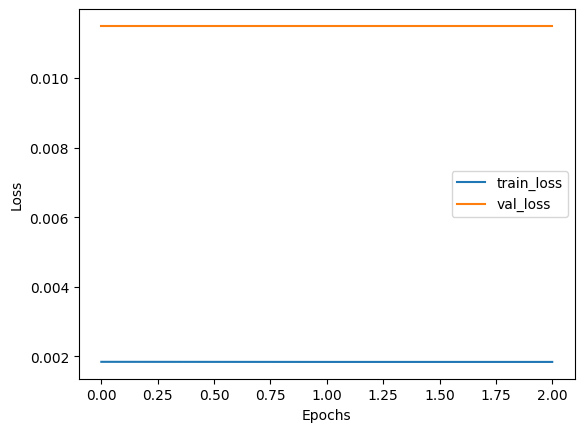

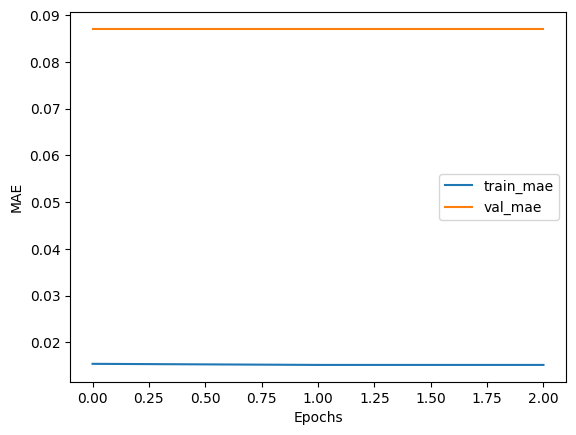

In [260]:
plot_training_history(compile_and_fit_embeddings(base_model_embedding,X_text_train,y_train))

In [308]:
y

array([[0.00214994],
       [0.00216231],
       [0.00162619],
       ...,
       [0.54382583],
       [0.56059735],
       [0.58672791]])

### Financial data model

In [261]:
baseline_model_financial = Sequential()
baseline_model_financial.add(Dense(units=1))

In [281]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, return_sequences=True))
lstm_model.add(Dense(units=1))

In [262]:
financial_model= Sequential()
financial_model.add(LSTM(units=64, return_sequences=True, input_shape=(X_financial_train.shape[1], 1)))
financial_model.add(LSTM(units=32))
financial_model.add(Dense(units=1))
visualkeras.layered_view(financial_model, to_file='financial_model.png').show() 

In [263]:
financial_model_1 = Sequential()
financial_model_1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_financial_train.shape[1], 1)))
financial_model_1.add(MaxPooling1D(pool_size=2))
financial_model_1.add(Bidirectional(LSTM(units=64, return_sequences=True)))
financial_model_1.add(Flatten())
financial_model_1.add(Dense(units=32, activation='relu'))
financial_model_1.add(Dropout(0.2))  # Optional dropout for regularization
financial_model_1.add(Dense(units=1, activation='linear'))  # Adjust units for regression tasks
visualkeras.layered_view(financial_model, to_file='financial_model_1.png').show()


In [ ]:
plot_training_history(compile_and_fit_financial(financial_model_1,X_financial_train,y_train, epochs=20, patience=1))

In [293]:
h = compile_and_fit_financial(baseline_model_financial,X_financial_train,y_train, epochs=20, patience=1)

Epoch 1/20
71/71 [==============================] - 0s 2ms/step - loss: 8.3409e-06 - mean_absolute_error: 0.0015 - val_loss: 5.3279e-05 - val_mean_absolute_error: 0.0049
Epoch 2/20
71/71 [==============================] - 0s 1ms/step - loss: 9.0780e-06 - mean_absolute_error: 0.0016 - val_loss: 3.9799e-05 - val_mean_absolute_error: 0.0045
Epoch 3/20
71/71 [==============================] - 0s 1ms/step - loss: 8.4656e-06 - mean_absolute_error: 0.0016 - val_loss: 6.2823e-05 - val_mean_absolute_error: 0.0055


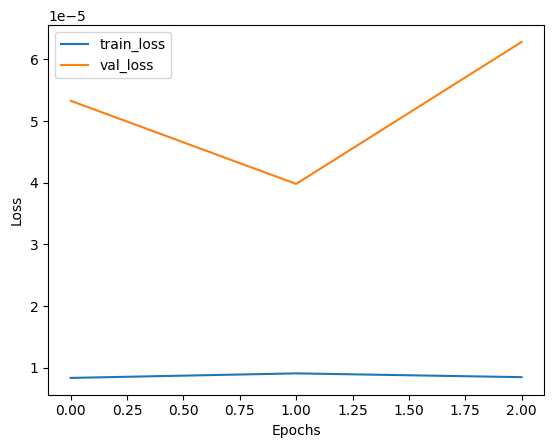

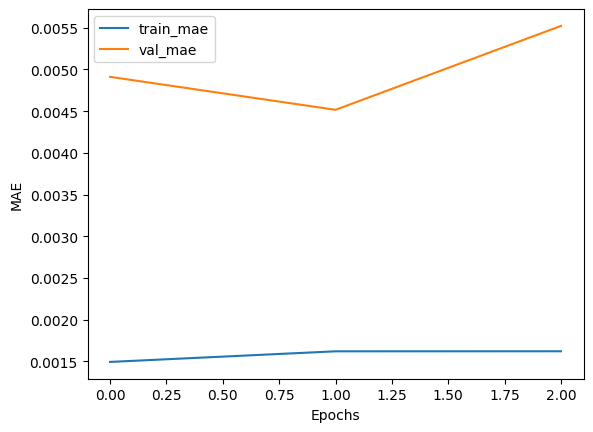

In [294]:
plot_training_history(h)

### Combined model

In [305]:
# Concatenate the outputs of both models
combined_input = Concatenate()([text_model.output, financial_model.output])
x = Dense(64, activation='relu')(combined_input)
output = Dense(1, activation='linear')(x)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min')
combined_model = tf.keras.Model(inputs=[text_model.input, financial_model.input], outputs=output)

visualkeras.layered_view(financial_model, to_file='combined_model.png').show() 

Epoch 1/800
71/71 [==============================] - 7s 48ms/step - loss: 0.0013 - mean_absolute_error: 0.0184 - val_loss: 0.0134 - val_mean_absolute_error: 0.0970
Epoch 2/800
71/71 [==============================] - 3s 39ms/step - loss: 0.0020 - mean_absolute_error: 0.0259 - val_loss: 0.0073 - val_mean_absolute_error: 0.0672
Epoch 3/800
71/71 [==============================] - 3s 39ms/step - loss: 0.0019 - mean_absolute_error: 0.0247 - val_loss: 0.0069 - val_mean_absolute_error: 0.0656
Epoch 4/800
71/71 [==============================] - 3s 38ms/step - loss: 0.0019 - mean_absolute_error: 0.0246 - val_loss: 0.0072 - val_mean_absolute_error: 0.0670
Epoch 5/800
71/71 [==============================] - 3s 39ms/step - loss: 0.0020 - mean_absolute_error: 0.0258 - val_loss: 0.0070 - val_mean_absolute_error: 0.0662
Epoch 6/800
71/71 [==============================] - 3s 38ms/step - loss: 0.0019 - mean_absolute_error: 0.0235 - val_loss: 0.0074 - val_mean_absolute_error: 0.0679


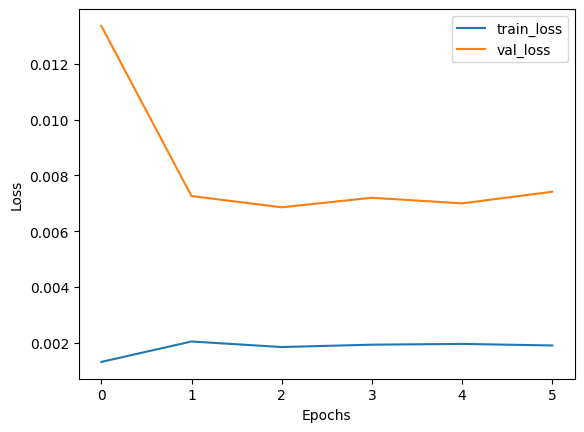

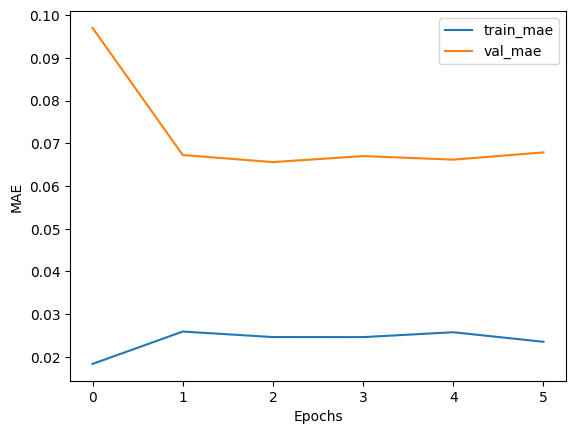

In [307]:
plot_training_history(compile_and_fit_combined(combined_model,X_text_train,X_financial_train,y_train, epochs=800, patience=3))

In [ ]:
# Evaluate the model
loss = combined_model.evaluate([X_text_test, X_financial_test], y_test)
print(f'Test Loss: {loss}')
# Make predictions
predictions = combined_model.predict([X_text_test, X_financial_test])

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(combined_model, show_shapes=True)

### Windows Generator

### Build a Baseline Model

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self,label_index = None):
        super().__init__()
        self.label_index = label_index

    def call(self,inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:,:, self.label_index]
        return result[:,:, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['Close'])

In [ ]:
val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

In [ ]:
val_performance

### Create linear model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import LSTM,Conv1D, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D,Dropout,BatchNormalization,ReLU,Concatenate

In [ ]:
linear = Sequential()
linear.add(Dense(units=1))

In [ ]:
compile_and_fit(linear, single_step_window)

In [ ]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
val_performance

### Dense Model

In [ ]:
dense = Sequential()
dense.add(Dense(units=64, activation='relu'))
dense.add(Dense(units=64, activation='relu'))
dense.add(Dense(units=1))

In [ ]:
compile_and_fit(dense, single_step_window)

In [ ]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
val_performance